In [126]:
# ===== Libraries =====
import cv2
# import pytesseract
from matplotlib import pyplot as plt
import numpy as np
import tkinter as Tk

# Check if tkinter is available
try:
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    #for some reason, this works despite the fact that tkinter is not installed in the environment
    #manually change this variable to True if you want to use the file dialog
    #tkinter_available = True
    tkinter_available = False
except:
    print("tkinter library not found. File dialog will not be available.")
    tkinter_available = False

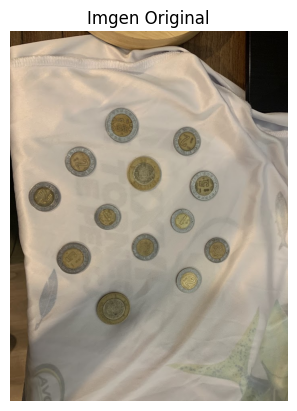

In [127]:
# ========== LOAD IMAGE ==========

if tkinter_available:
    Tk().withdraw()  
    file_name = askopenfilename(title="Select an image file", filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")])
else:
    file_name = "images/IMG_0494.jpg"  #

imagen = cv2.imread(file_name)

imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.imshow(imagen)
plt.axis('off') 
plt.title("Imgen Original")
plt.show()

(<Axes: title={'center': 'Suavizado'}>,
 Text(0.5, 1.0, 'Suavizado'))

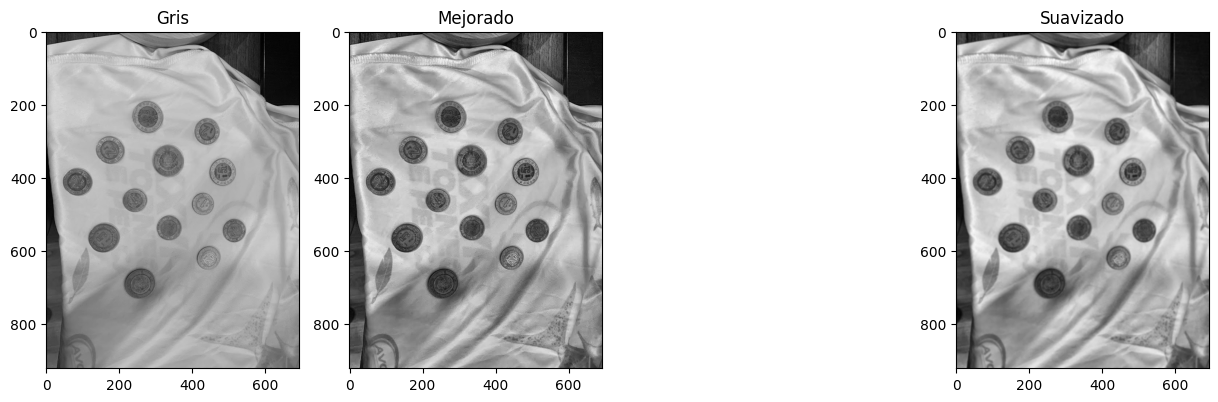

In [128]:
# ========== IMPROVED PREPROCESSING ==========
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Mejorar contraste con CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)



# Kernel dinámico basado en resolución
altura, anchura = gray.shape
kernel_size = max(3, int(min(altura, anchura) * 0.01))
if kernel_size % 2 == 0:  # kernel debe ser impar
	kernel_size += 1
gauss = cv2.GaussianBlur(gray_enhanced, (kernel_size, kernel_size), 0)

#print out the images to see the difference
# Create a figure with appropriate size
plt.figure(figsize=(15, 5))

# Display the preprocessing stages
plt.subplot(1, 4, 1), plt.imshow(gray, cmap='gray'), plt.title('Gris')
plt.subplot(1, 4, 2), plt.imshow(gray_enhanced, cmap='gray'), plt.title('Mejorado')
plt.subplot(1, 4, 4), plt.imshow(gauss, cmap='gray'), plt.title('Suavizado')





Monedas detectadas: 13
Valores detectados: [2, 1, 1, 5, 5, 10, 2, 10, 10, 10, 5, 2, 2]
Total en dinero: 65


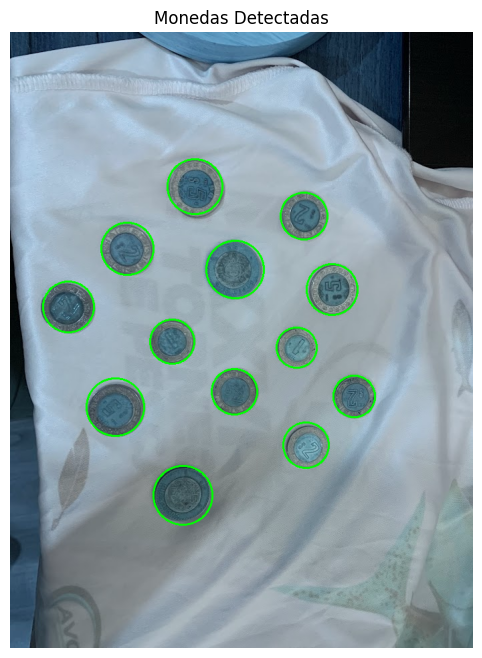

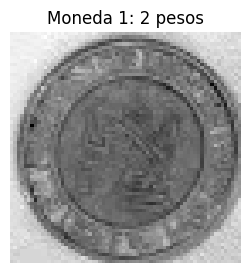

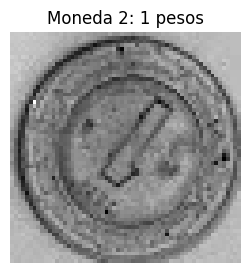

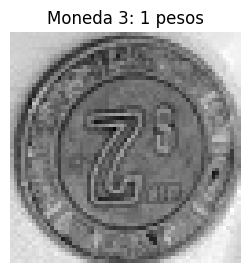

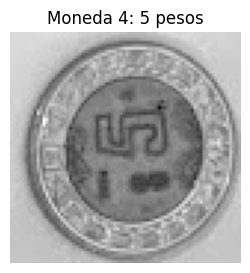

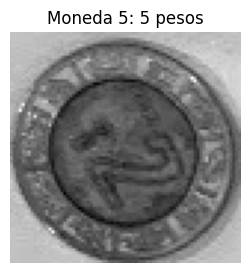

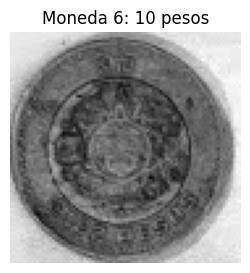

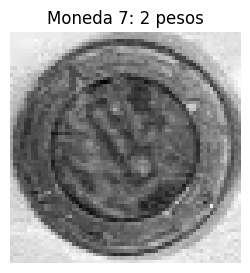

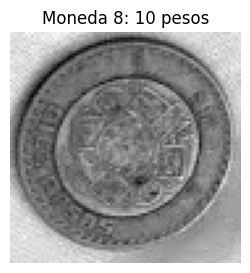

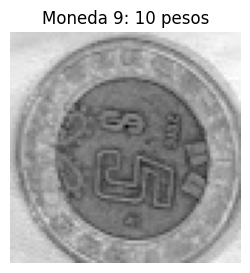

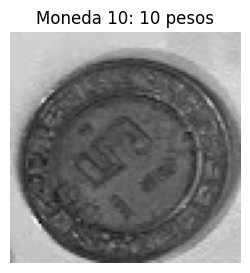

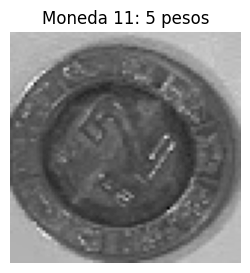

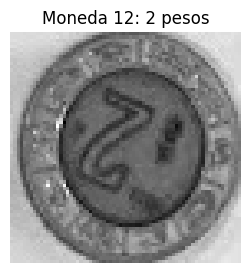

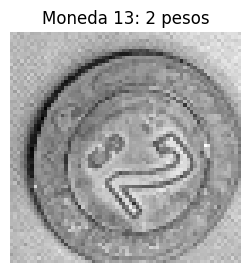

In [129]:
# ========== DETECCIÓN DE CÍRCULOS ==========
min_dim = min(altura, anchura)
min_radius = min_dim * 0.03  # radio mínimo (3% de dim menor)
max_radius = min_dim * 0.1   # radio máximo (10% de dim menor)

# detectar círculos en la imagen
circles = cv2.HoughCircles(
	gauss, 
	cv2.HOUGH_GRADIENT, 
	dp=1, 
	minDist=min_radius * 2,
	param1=150, 
	param2=30, 
	minRadius=int(min_radius), 
	maxRadius=int(max_radius)
)

total_monedas = 0
valores_detectados = []

if circles is not None:
	circles = circles[0]
	
	# filtrar círculos concéntricos
	filtered_circles = []
	
	for x1, y1, r1 in circles:
		is_concentric = False
		
		for j, (x2, y2, r2) in enumerate(filtered_circles):
			# si los centros están muy cercanos
			if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < r2 * 0.5:
				is_concentric = True
				if r1 > r2:  # reemplazar con el más grande
					filtered_circles[j] = (x1, y1, r1)
				break
		
		if not is_concentric:
			filtered_circles.append((x1, y1, r1))
	
	total_monedas = len(filtered_circles)
	
	if total_monedas > 0:
		# extraer radios
		radios = [r for _, _, r in filtered_circles]
		
		# ===== CLASIFICACIÓN SIMPLIFICADA =====
		# umbral para considerar que pertenecen al mismo grupo
		umbral_porcentaje = 5
		
		# ordenamos radios de menor a mayor
		radios_ordenados = sorted(radios)
		
		# inicializamos 4 grupos vacíos
		grupos = [[] for _ in range(4)]
		grupo_actual = 0
		grupos[0].append(radios_ordenados[0])
		
		# recorremos cada radio, empezando por el segundo
		for i in range(1, len(radios_ordenados)):
			radio_actual = radios_ordenados[i]
			radio_anterior = radios_ordenados[i-1]
			
			# calculamos el porcentaje de incremento
			incremento = (radio_actual - radio_anterior) / radio_anterior * 100
			
			# si hay un salto significativo y aún tenemos grupos disponibles
			if incremento > umbral_porcentaje and grupo_actual < 3:
				grupo_actual += 1
			
			# agregamos el radio al grupo actual
			grupos[grupo_actual].append(radio_actual)
		
		# valores de monedas por grupo (de menor a mayor tamaño)
		valores_monedas = [1, 2, 5, 10]
		
		# crear mapeo radio -> valor
		radio_a_valor = {}
		for idx, grupo in enumerate(grupos):
			for radio in grupo:
				radio_a_valor[radio] = valores_monedas[idx]
		
		# procesar monedas
		for x, y, r in filtered_circles:
			cv2.circle(imagen, (int(x), int(y)), int(r), (0, 255, 0), 2)
			valores_detectados.append(radio_a_valor.get(r, 10))


# ========== MOSTRAR RESULTADOS ==========
print(f"Monedas detectadas: {total_monedas}")
print(f"Valores detectados: {valores_detectados}")
print(f"Total en dinero: {sum(valores_detectados) if valores_detectados else 0}")

# visualizar imagen con todas las monedas detectadas
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title("Monedas Detectadas")
plt.show()

# mostrar cada moneda en una imagen individual
if circles is not None and total_monedas > 0:
	for i, ((x, y, r), valor) in enumerate(zip(filtered_circles, valores_detectados)):
		# extraer región de interés
		x1, y1 = max(0, int(x - r)), max(0, int(y - r))
		x2, y2 = min(anchura - 1, int(x + r)), min(altura - 1, int(y + r))
		
		# crear nueva figura para cada moneda
		plt.figure(figsize=(3, 3))
		plt.imshow(gray[y1:y2, x1:x2], cmap='gray')
		plt.axis('off')
		plt.title(f"Moneda {i+1}: {valor} pesos")
		plt.show()
else:
	print("No se detectaron monedas en la imagen.")